# Marketing Campaign Analysis



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
#!pip install -U seaborn

In [2]:
df = pd.read_csv('../data/marketing_campaign.csv',sep =';')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

We have 3 categorical variables, and 26 numerical variables
We have 24 null values in the Income column.

In [4]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

Printing the data points with null values below.

In [5]:
null_income_df = df[df['Income'].isnull()]
print(null_income_df[:10])

        ID  Year_Birth   Education Marital_Status  Income  Kidhome  Teenhome  \
10    1994        1983  Graduation        Married     NaN        1         0   
27    5255        1986  Graduation         Single     NaN        1         0   
43    7281        1959         PhD         Single     NaN        0         0   
48    7244        1951  Graduation         Single     NaN        2         1   
58    8557        1982  Graduation         Single     NaN        1         0   
71   10629        1973    2n Cycle        Married     NaN        1         0   
90    8996        1957         PhD        Married     NaN        2         1   
91    9235        1957  Graduation         Single     NaN        1         1   
92    5798        1973      Master       Together     NaN        0         0   
128   8268        1961         PhD        Married     NaN        0         1   

    Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
10   2013-11-15       11         5  ...    

# Handling missing values and Feature Engineering

We will handle missing values by approximating them with KNN. But first we will need to proceed with feature engineering so that we can handle the missing values more accurately.

In [6]:
# HasChild
df.loc[(df['Kidhome'] > 0) | (df['Teenhome'] > 0), 'HasChild'] = "Yes"
df.loc[(df['Kidhome'] == 0) & (df['Teenhome'] == 0), 'HasChild'] = "No"
df.drop(['Kidhome','Teenhome'], axis=1, inplace=True)

#Age
currentYear = datetime.now().year
df['Year_Birth'] = currentYear - df['Year_Birth']
df.rename(columns={'Year_Birth':'Age'}, inplace=True)

#Marital Status
df['Marital_Status'] = df['Marital_Status'].apply(lambda x: 'In Couple'
if x == 'Together' or x == 'Married' else 'Single')

#Educational Years
def educ_years(x):
    if x == 'Graduation':
        return 12
    elif x == 'PhD':
        return 21
    elif x == 'Master':
        return 18
    elif x == 'Basic':
        return 5
    elif x == '2n Cycle':
        return 8


df['Educational_Years'] = df['Education'].apply(educ_years)


#Spending
df['Spending'] = df['MntFishProducts'] + df['MntMeatProducts'] + df['MntFruits']\
                 + df['MntSweetProducts'] + df['MntWines'] + df['MntGoldProds']

#Seniority (number of months in company)
currentTime = datetime.now()
def seniority_func(x):
    date_format = '%Y-%m-%d'
    #convert string to date, find delta
    x = datetime.strptime(x,date_format)
    delta = currentTime - x
    return delta.days / 30.417 #Formula by Google.


df['Seniority'] = df['Dt_Customer'].apply(seniority_func)

#Drop excess columns
df.drop(['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5'
            ,'Response','Complain','Dt_Customer', 'Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

In [7]:
df[['Age','Income','Spending','Educational_Years','Seniority']].describe()

,Age,Income,Spending,Educational_Years,Seniority
count,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000
mean,52.194196,52247.251354,605.798214,14.412500,94.078382
std,11.984069,25173.076661,602.249288,4.510068,6.645051
min,25.000000,1730.000000,5.000000,5.000000,82.453891
25%,44.000000,35303.000000,68.750000,12.000000,88.396292
50%,51.000000,51381.500000,396.000000,12.000000,94.141434
75%,62.000000,68522.000000,1045.500000,18.000000,99.845481
max,128.000000,666666.000000,2525.000000,21.000000,105.434461


Text(0.5, 1.0, 'Seniority boxplot')

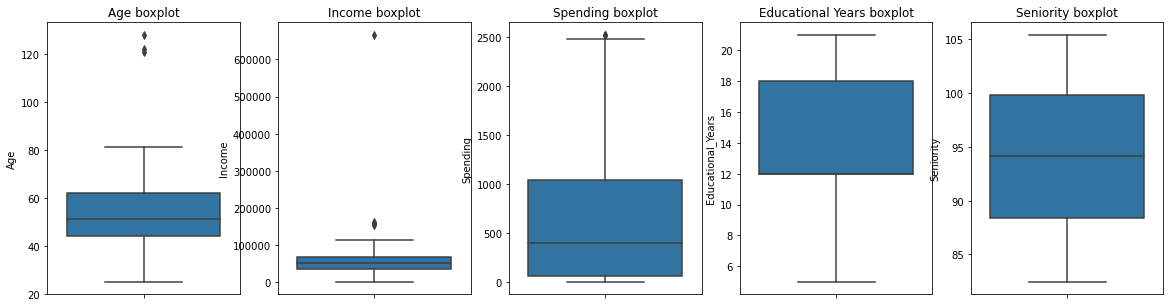

In [8]:
f, axes = plt.subplots(ncols=5, figsize=(20,5))
sns.boxplot(y="Age",data=df,ax=axes[0])
axes[0].set_title("Age boxplot")

sns.boxplot(y="Income",data=df,ax=axes[1])
axes[1].set_title("Income boxplot")

sns.boxplot(y="Spending",data=df,ax=axes[2])
axes[2].set_title("Spending boxplot")

sns.boxplot(y="Educational_Years",data=df,ax=axes[3])
axes[3].set_title("Educational Years boxplot")

sns.boxplot(y="Seniority",data=df,ax=axes[4])
axes[4].set_title("Seniority boxplot")

We will remove the extreme outlier in the income feature which is 666k. All other outliers are mild and acceptible, so there is no need for IQR.

In [9]:
df = df.drop(df[df.Income == max(df.Income)].index)

## Handling missing values
Since we found missing values in the Income feature, we will approximate them with KNN.

In [10]:
imputer = KNNImputer(n_neighbors=5,metric='nan_euclidean')
# fit on the dataset
imputer.fit(df[['Income', 'Age', 'Educational_Years', 'Spending']])
# transform the dataset
X = imputer.transform(df[['Income', 'Age', 'Educational_Years', 'Spending']])
Income_impute = pd.DataFrame(X, columns=['Income', 'Age', 'Educational_years', 'Spending'])
df['Income'] = Income_impute['Income'].reset_index(drop=True)

print(df.isnull().sum())
print(df[df['Income'] == None])
df = df.dropna()

ID                     0
Age                    0
Education              0
Marital_Status         0
Income                 1
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
HasChild               0
Educational_Years      0
Spending               0
Seniority              0
dtype: int64
Empty DataFrame
Columns: [ID, Age, Education, Marital_Status, Income, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, HasChild, Educational_Years, Spending, Seniority]
Index: []

[0 rows x 21 columns]


## Data Scaling
Standardization scales each input variable separately by subtracting the mean (called centering) and dividing by the standard deviation to shift the distribution to have a mean of zero and a standard deviation of one.

Normalization scales each input variable separately to the range 0-1, which is the range for floating-point values where we have the most precision.

### Should we normalize or standardize?
If the distribution of the quantity is normal, then it should be standardized, otherwise, the data should be normalized.
We will use StandardScaler to normalize the data. The features we are going to normalize are Income, Age, Educational_Years, Spending, and Seniority.

### Why not both?
It may be desirable to normalize data after it has been standardized.

This might be a good idea of you have a mixture of standardized and normalized variables and wish all input variables to have the same minimum and maximum values as input for a given algorithm, such as an algorithm that calculates distance measures.

We will explore the benefits of standardizing and then normalizing the data.

![title](../standardization_vs_normalization.png)

In [11]:
#Standardization
scaler = StandardScaler()
scaled_df = df.copy()
col_names = ['Income','Spending', 'Seniority']
features = scaled_df[col_names]
scaler = scaler.fit(features.values)
features = scaler.transform(features.values)
scaled_df[col_names] = features

#Normalization
transformer = Normalizer()
col_names = ['Income','Spending', 'Seniority']
features = scaled_df[col_names]
transformer = transformer.fit(features.values)
features = transformer.transform(features.values)
scaled_df[col_names] = features

In [12]:
scaled_df[['Income','Spending','Seniority']].describe()

,Income,Spending,Seniority
count,2238.000000,2238.000000,2238.000000
mean,-0.017551,-0.078715,0.000638
std,0.550553,0.567155,0.607590
min,-0.991569,-0.998583,-0.999298
25%,-0.541238,-0.545059,-0.589558
50%,-0.022951,-0.334403,0.009035
75%,0.496327,0.511063,0.563609
max,0.986625,0.954710,0.999008


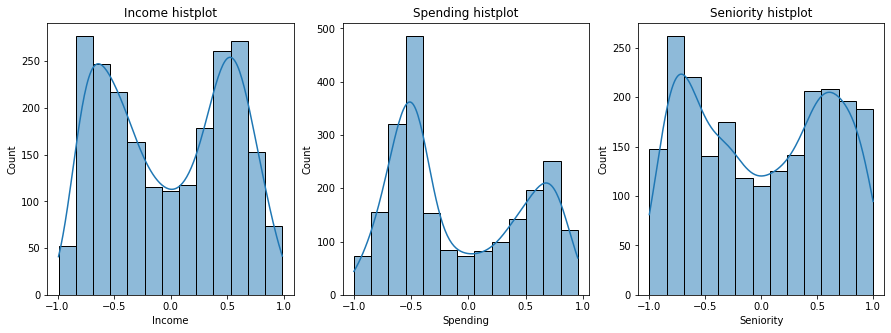

In [13]:
f, axes = plt.subplots(ncols=3, figsize=(15,5))
sns.histplot(x="Income",data=scaled_df,ax=axes[0], kde=True)
axes[0].set_title("Income histplot")

sns.histplot(x="Spending",data=scaled_df,ax=axes[1], kde=True)
axes[1].set_title("Spending histplot")

sns.histplot(x="Seniority",data=scaled_df,ax=axes[2], kde=True)
axes[2].set_title("Seniority histplot")
plt.show()

# Clustering
We will try different clustering algorithms. First we need to determine the optimal value of K for the number of clusters.

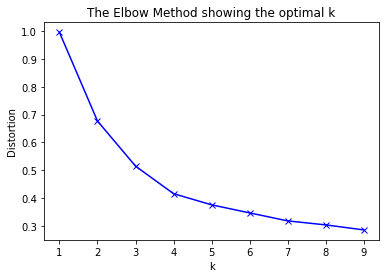

In [14]:
#Elbow method for determining the number of clusters
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(scaled_df[col_names])
    kmeanModel.fit(scaled_df[col_names])
    distortions.append(sum(np.min(cdist(scaled_df[col_names], kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / scaled_df[col_names].shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


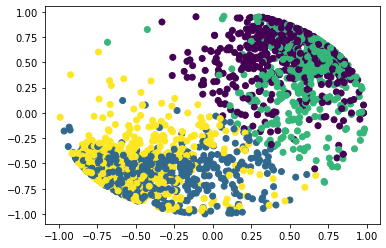

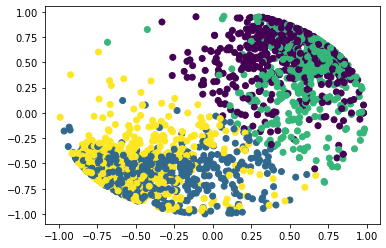

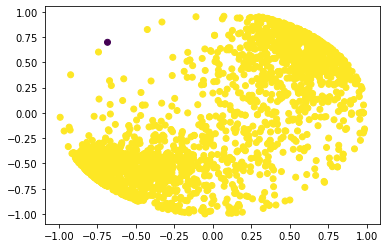

In [15]:
#KMEANS++
kmeanModel = kmeanModel = KMeans(n_clusters=4, init="k-means++", max_iter=2000, random_state=42).fit(features)
labels = kmeanModel.predict(features)
plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
plt.show()

#Gaussian Mixture
gmm=GaussianMixture(n_components=4, covariance_type='spherical',max_iter=2000, random_state=42).fit(features)
labels_gmm = gmm.predict(features)
plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
plt.show()

#DBSCAN
dbscan = DBSCAN(eps=0.5).fit(features)
plt.scatter(features[:, 0], features[:, 1], c=dbscan.labels_, cmap='viridis')

# Clustering Evaluation

We will use the Silhouette score to evaluate the clustering algorithms formally, though it is also evident through the cluster visualizations above that Kmeans++ and GMM have similiar, almost identical performance, and DBSCAN is performing poorly due to the variation of density in the data. The silhouette score should also reflect this observation.

We are using the cosine distance metric because in higher dimensions, euclidian distances have very little meaning since they are often very close together.

In [16]:
print('kmeans: {}'.format(silhouette_score(features, kmeanModel.labels_,
                                           metric='cosine')))

print('GMM: {}'.format(silhouette_score(features, labels_gmm,
                                           metric='cosine')))

print('DBSCAN: {}'.format(silhouette_score(features, dbscan.labels_,
                                           metric='cosine')))

kmeans: 0.6460437751502568
GMM: 0.645892616154554
DBSCAN: 0.01320248170505405


# Cluster Interpretation

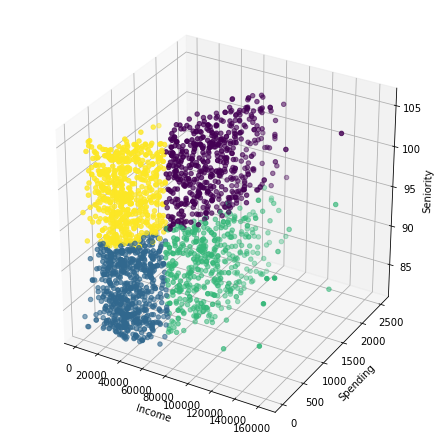

In [26]:
scaled_df['Cluster'] = labels_gmm
df['Cluster'] = labels_gmm

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

x = df['Income']
y = df['Spending']
z = df['Seniority']
c = df['Cluster']

ax.set_xlabel("Income")
ax.set_ylabel("Spending")
ax.set_zlabel("Seniority")

ax.scatter(xs=x,ys=y,zs=z,c=c)

Now that we have segmented our customers it would be nice if we would know what makes each cluster unique. This will help us understand which types of customers we have.

In [23]:
df_mean = (df.groupby('Cluster').mean())
df_mean['Count'] = df['Cluster'].value_counts()
df_mean['Percent'] = (df_mean['Count'] / df_mean['Count'].sum())*100
print(df_mean[['Income','Spending','Seniority','Count','Percent']])

def cluster_func(x):
    if x == 0:
        return 'Stars'
    elif x == 1:
        return 'Need attention'
    elif x == 2:
        return 'High potential'
    elif x == 3:
        return 'Leaky bucket'

df['Cluster'] = df['Cluster'].apply(cluster_func)

               Income     Spending   Seniority  Count    Percent
Cluster                                                         
0        69440.268037  1242.297196  100.021907    535  23.905273
1        37975.426340   124.978560   88.227693    653  29.177837
2        73528.883983  1082.848485   88.437174    462  20.643432
3        34602.426190   187.479592   99.583253    588  26.273458


- Cluster0 (**Stars**) are customers with **high** Income, Spending and Seniority. We have 535 such instances, or 23,9%
- Cluster1 (**Need attention**) are customers with **low** Income, Spending and Seniority. We have 653 such instances, or 29,1%
- Cluster2 (**High potential**) are customers with **high** Income and Spending, and **low** Seniority. We have 462 such instances, or 20,6%
- Cluster3 (**Leaky bucket**) are customers with **low** Income and Spending, and **high** Seniority. We have 588 such instances or 26,7%

As we can see, the cluster with the most customers is Cluster1 which are low income,spending and seniority.
The cluster with the least customers is Cluster2, which are high in spending and income, and low in seniority.

The stars cluster is our best marketing target, since they are our old customers who are spending a lot.
The high potential cluster is the second best marketing target, because they are spending a lot, but they are newer and require some attention.